<a href="https://colab.research.google.com/github/purusottamjena/CPPUtest/blob/main/dataset_athrvcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 for initializations

In [1]:
# Install required packages (if not already installed)
!pip install pandas matplotlib seaborn plotly

# Import required libraries
import os
import re
import csv
import json
import uuid
import zipfile
from pathlib import Path
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files, drive
import plotly.express as px
import plotly.graph_objects as go

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


Cell 2: Upload Your Project Files

In [2]:
# Initialize variables
project_path = "/content/project_files"
os.makedirs(project_path, exist_ok=True)

# Keep track of uploaded files
uploaded_files_info = []

def display_uploaded_files():
    """Display currently uploaded files"""
    if not uploaded_files_info:
        print("📝 No files uploaded yet.")
        return

    print(f"\n📂 Currently uploaded files ({len(uploaded_files_info)} total):")
    print("-" * 60)

    # Group by file type
    c_files = [f for f in uploaded_files_info if f['extension'] == '.c']
    h_files = [f for f in uploaded_files_info if f['extension'] in ['.h', '.hpp']]
    cpp_files = [f for f in uploaded_files_info if f['extension'] in ['.cpp', '.cc', '.cxx']]
    other_files = [f for f in uploaded_files_info if f not in c_files + h_files + cpp_files]

    if c_files:
        print(f"🔵 .c files ({len(c_files)}):")
        for f in c_files:
            original_name = f.get('original_name', f['name'])
            if original_name != f['name']:
                print(f"   📄 {f['name']} (original: {original_name}) ({f['size']:.1f} KB)")
            else:
                print(f"   📄 {f['name']} ({f['size']:.1f} KB)")

    if h_files:
        print(f"🟢 .h files ({len(h_files)}):")
        for f in h_files:
            original_name = f.get('original_name', f['name'])
            if original_name != f['name']:
                print(f"   📄 {f['name']} (original: {original_name}) ({f['size']:.1f} KB)")
            else:
                print(f"   📄 {f['name']} ({f['size']:.1f} KB)")

    if cpp_files:
        print(f"🟡 .cpp files ({len(cpp_files)}):")
        for f in cpp_files:
            original_name = f.get('original_name', f['name'])
            if original_name != f['name']:
                print(f"   📄 {f['name']} (original: {original_name}) ({f['size']:.1f} KB)")
            else:
                print(f"   📄 {f['name']} ({f['size']:.1f} KB)")

    if other_files:
        print(f"⚪ Other files ({len(other_files)}):")
        for f in other_files:
            original_name = f.get('original_name', f['name'])
            if original_name != f['name']:
                print(f"   📄 {f['name']} (original: {original_name}) ({f['size']:.1f} KB)")
            else:
                print(f"   📄 {f['name']} ({f['size']:.1f} KB)")

def upload_individual_files():
    """Upload individual files with support for multiple uploads and duplicate handling"""
    supported_extensions = ['.c', '.h', '.cpp', '.cc', '.cxx', '.hpp']
    supported_files = ['cmakelists.txt', 'makefile']

    print("📁 Upload Individual Files")
    print("=" * 50)
    print("Supported file types:")
    print("  🔵 .c files (C source)")
    print("  🟢 .h files (C/C++ headers)")
    print("  🟡 .cpp/.cc/.cxx files (C++ source)")
    print("  🟣 CMakeLists.txt, Makefile")
    print("\n💡 You can upload multiple files at once!")
    print("💡 Duplicate file names are automatically handled!")
    print("💡 All files will be uploaded, none will be skipped due to name conflicts.")

    # Show currently uploaded files
    display_uploaded_files()

    print(f"\n📤 Click 'Choose Files' to upload:")
    uploaded = files.upload()

    files_processed = 0
    files_skipped = 0

    # Keep track of file name counters to handle duplicates
    file_name_counters = {}

    for filename, content in uploaded.items():
        file_extension = os.path.splitext(filename)[1].lower()
        file_basename = os.path.basename(filename).lower()
        original_filename = filename

        # Check if file is supported
        if file_extension in supported_extensions or file_basename in supported_files:
            # Create subdirectories based on file type for organization
            if file_extension in ['.cpp','.c', '.cc', '.cxx']:
                subdir = "src"
            elif file_extension in ['.h', '.hpp']:
                subdir = "inc"
            # elif file_extension in ['.cpp', '.cc', '.cxx']:
            #     subdir = "test"
            elif file_basename in ['cmakelists.txt', 'makefile']:
                subdir = "build"
            else:
                subdir = "other"

            # Create subdirectory
            file_dir = os.path.join(project_path, subdir)
            os.makedirs(file_dir, exist_ok=True)

            # Handle duplicate file names
            base_name = os.path.splitext(filename)[0]
            extension = os.path.splitext(filename)[1]

            # Check if this file name already exists
            existing_files = [f['name'] for f in uploaded_files_info
                            if f['category'] == subdir and f['name'].startswith(base_name)]

            if existing_files:
                # Create unique filename by adding timestamp
                import time
                timestamp = int(time.time() * 1000) % 100000  # Last 5 digits of timestamp
                unique_filename = f"{base_name}_{timestamp}{extension}"

                # Double check for extremely rare collision
                counter = 1
                while any(f['name'] == unique_filename for f in uploaded_files_info):
                    unique_filename = f"{base_name}_{timestamp}_{counter}{extension}"
                    counter += 1

                final_filename = unique_filename
                print(f"📝 Renamed duplicate: {filename} → {final_filename}")
            else:
                final_filename = filename

            # Save file with the final filename
            file_path = os.path.join(file_dir, final_filename)
            with open(file_path, 'wb') as f:
                f.write(content)

            # Track file info
            file_size_kb = len(content) / 1024
            uploaded_files_info.append({
                'name': final_filename,  # Store the final unique filename
                'original_name': original_filename,  # Store the original filename
                'path': file_path,
                'extension': file_extension,
                'size': file_size_kb,
                'category': subdir
            })

            files_processed += 1
            print(f"✅ {final_filename} → {subdir}/")
        else:
            files_skipped += 1
            print(f"⚠️  Skipped {filename} (unsupported file type)")

    print(f"\n📊 Upload Summary:")
    print(f"  ✅ Files processed: {files_processed}")
    print(f"  ⚠️  Files skipped: {files_skipped}")
    print(f"  📁 Total files uploaded: {len(uploaded_files_info)}")

    return len(uploaded_files_info) > 0

# Method selection
print("🔄 Choose upload method:")
print("1. Upload ZIP file (entire project)")
print("2. Upload individual files (.c, .h, .cpp, CMakeLists.txt)")
print("3. Connect Google Drive")

upload_method = input("Enter choice (1, 2, or 3): ")

if upload_method == "1":
    print("📁 Please upload your project ZIP file:")
    uploaded = files.upload()

    # Extract the ZIP file
    for filename in uploaded.keys():
        if filename.endswith('.zip'):
            print(f"📦 Extracting {filename}...")
            with zipfile.ZipFile(filename, 'r') as zip_ref:
                zip_ref.extractall(project_path)
            print(f"✅ Project extracted to {project_path}")

            # Scan extracted files and populate uploaded_files_info
            for root, dirs, files in os.walk(project_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    file_extension = os.path.splitext(file)[1].lower()
                    file_size = os.path.getsize(file_path) / 1024

                    uploaded_files_info.append({
                        'name': file,
                        'path': file_path,
                        'extension': file_extension,
                        'size': file_size,
                        'category': os.path.basename(root)
                    })
            break
    else:
        print("❌ No ZIP file found. Please upload a ZIP file.")

elif upload_method == "2":
    # Individual file upload with multiple rounds
    upload_individual_files()

    # Option to upload more files
    while True:
        print(f"\n" + "="*50)
        choice = input("Would you like to upload more files? (y/N): ").lower()
        if choice == 'y':
            upload_individual_files()
        else:
            break

    # Final summary
    print(f"\n🎉 Upload Complete!")
    display_uploaded_files()

elif upload_method == "3":
    # Mount Google Drive
    drive.mount('/content/drive')
    project_path = input("📁 Enter the path to your project in Google Drive (e.g., /content/drive/MyDrive/my_project): ")
    if os.path.exists(project_path):
        print(f"✅ Connected to {project_path}")

        # Scan Google Drive files and populate uploaded_files_info
        for root, dirs, files in os.walk(project_path):
            for file in files:
                file_path = os.path.join(root, file)
                file_extension = os.path.splitext(file)[1].lower()
                try:
                    file_size = os.path.getsize(file_path) / 1024
                except:
                    file_size = 0

                uploaded_files_info.append({
                    'name': file,
                    'path': file_path,
                    'extension': file_extension,
                    'size': file_size,
                    'category': os.path.basename(root)
                })
    else:
        print(f"❌ Path {project_path} not found.")

else:
    print("❌ Invalid choice. Please run this cell again.")

# Validate that we have files
if uploaded_files_info:
    print(f"\n✅ Ready to process {len(uploaded_files_info)} files!")
    display_uploaded_files()
else:
    print(f"\n❌ No files uploaded. Please try again.")

🔄 Choose upload method:
1. Upload ZIP file (entire project)
2. Upload individual files (.c, .h, .cpp, CMakeLists.txt)
3. Connect Google Drive
Enter choice (1, 2, or 3): 2
📁 Upload Individual Files
Supported file types:
  🔵 .c files (C source)
  🟢 .h files (C/C++ headers)
  🟡 .cpp/.cc/.cxx files (C++ source)
  🟣 CMakeLists.txt, Makefile

💡 You can upload multiple files at once!
💡 Duplicate file names are automatically handled!
💡 All files will be uploaded, none will be skipped due to name conflicts.
📝 No files uploaded yet.

📤 Click 'Choose Files' to upload:


Saving visible_on_screen_notifier_2d.h to visible_on_screen_notifier_2d.h
Saving visible_on_screen_notifier_2d.cpp to visible_on_screen_notifier_2d.cpp
Saving tile_map_layer.h to tile_map_layer.h
Saving tile_map_layer.cpp to tile_map_layer.cpp
Saving tile_map.h to tile_map.h
Saving tile_map.cpp to tile_map.cpp
Saving tile_map.compat.inc to tile_map.compat.inc
Saving sprite_2d.h to sprite_2d.h
Saving sprite_2d.cpp to sprite_2d.cpp
Saving skeleton_2d.h to skeleton_2d.h
Saving skeleton_2d.cpp to skeleton_2d.cpp
Saving remote_transform_2d.h to remote_transform_2d.h
Saving remote_transform_2d.cpp to remote_transform_2d.cpp
Saving polygon_2d.h to polygon_2d.h
Saving polygon_2d.cpp to polygon_2d.cpp
Saving touch_screen_button.h to touch_screen_button.h
Saving touch_screen_button.cpp to touch_screen_button.cpp
Saving static_body_2d.h to static_body_2d.h
Saving static_body_2d.cpp to static_body_2d.cpp
Saving shape_cast_2d.h to shape_cast_2d.h
Saving shape_cast_2d.cpp to shape_cast_2d.cpp
Saving

Cell 3: Define the Dataset Creator Class

In [3]:
class GroupedEmbeddedDatasetCreator:
    def __init__(self, codebase_path, output_dir="/content/output"):
        self.codebase_path = Path(codebase_path)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Define which directories to include/exclude
        self.include_dirs = [
            "Core/Src",
            "Core/Inc",
            "Src",      # Common source directory
            "Inc",      # Common include directory
            "src",      # Lowercase version
            "include"   # Include directory
        ]

        # Exclude vendor/generated files
        self.exclude_dirs = [
            "Drivers/STM32F4xx_HAL_Driver",  # Vendor HAL drivers
            "Drivers/CMSIS",                 # CMSIS files
            "Debug",                         # Build artifacts
            "build",                         # Build artifacts
            "Build",                         # Build artifacts (uppercase)
            "__pycache__",                   # Python cache
            ".git",                          # Git directory
            "node_modules"                   # Node modules
        ]

        # Statistics
        self.stats = {
            'processed_files': 0,
            'skipped_files': 0,
            'groups_created': 0
        }

    def should_process_file(self, file_path):
        """Determine if a file should be included in the dataset"""
        try:
            # Convert path to string for easier comparison
            file_path_str = str(file_path)
            rel_path_str = str(file_path.relative_to(self.codebase_path))

            # Always process files with relevant extensions
            extension = file_path.suffix.lower()
            if extension in ['.c', '.h', '.hpp', '.cpp', '.cc', '.cxx']:
                # Check if file is in excluded directories
                for exclude_dir in self.exclude_dirs:
                    if exclude_dir in rel_path_str:
                        return False

                # If no include dirs specified, include all non-excluded
                if not self.include_dirs:
                    return True

                # If include dirs are specified, check if file is in one of them
                for include_dir in self.include_dirs:
                    if include_dir in rel_path_str:
                        return True

                # Default include if no specific include directories matched
                return True

            # Process CMakeLists.txt and Makefile
            filename = file_path.name.lower()
            if filename in ['cmakelists.txt', 'makefile']:
                return True

            # Skip other files
            return False
        except Exception as e:
            print(f"⚠️ Error checking file {file_path}: {e}")
            return False

    def read_file_content(self, file_path):
        """Read file content with error handling"""
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read().strip()
                if content:
                    self.stats['processed_files'] += 1
                    return content
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {e}")
            self.stats['skipped_files'] += 1

        return ""

    def find_all_files(self):
        """Find and categorize all relevant files"""
        files_by_type = {
            'source_files': {},  # basename -> list of file_paths (.c and .cpp files combined)
            'h_files': {},       # basename -> file_path (.h and .hpp files)
            'cmake_files': []    # list of cmake file paths
        }

        print("🔍 Scanning project directory...")

        # Walk through all files
        file_count = 0
        try:
            for file_path in self.codebase_path.rglob("*"):
                if not file_path.is_file():
                    continue

                file_count += 1
                if file_count % 100 == 0:
                    print(f" Scanned {file_count} files...")

                # Handle CMakeLists.txt files
                if file_path.name.lower() in ['cmakelists.txt', 'makefile']:
                    files_by_type['cmake_files'].append(file_path)
                    continue

                # Check if file should be processed
                if not self.should_process_file(file_path):
                    continue

                # Categorize by extension
                extension = file_path.suffix.lower()

                # Extract clean basename (remove suffix and extension)
                filename = file_path.stem
                clean_basename = re.sub(r'\s*\(\d+\)$', '', filename)

                # Combine .c and .cpp files as source files
                if extension in ['.c', '.cpp', '.cc', '.cxx']:
                    if clean_basename not in files_by_type['source_files']:
                        files_by_type['source_files'][clean_basename] = []
                    files_by_type['source_files'][clean_basename].append(file_path)
                elif extension in ['.h', '.hpp']:
                    files_by_type['h_files'][clean_basename] = file_path

        except Exception as e:
            print(f"⚠️ Error scanning files: {e}")
            traceback.print_exc()

        print(f"✅ Scan complete! Found {file_count} total files")
        print(f" 📄 Source files (.c/.cpp): {len(files_by_type['source_files'])}")
        print(f" 📄 Header files (.h/.hpp): {len(files_by_type['h_files'])}")
        print(f" 📄 CMake/Make files: {len(files_by_type['cmake_files'])}")

        return files_by_type

    def find_related_cmake(self, file_path, cmake_files):
        """Find the most relevant CMakeLists.txt for a given file"""
        if not cmake_files or not file_path:
            return "No CMakeLists.txt Found"

        try:
            # Find the closest CMakeLists.txt file (in same or parent directory)
            current_dir = file_path.parent
            while current_dir >= self.codebase_path:
                for cmake_file in cmake_files:
                    if cmake_file.parent == current_dir:
                        return self.read_file_content(cmake_file)

                current_dir = current_dir.parent

            # If no specific CMakeLists.txt found, return the first one found
            if cmake_files:
                return self.read_file_content(cmake_files[0])
        except Exception as e:
            print(f"⚠️ Error finding related CMake file: {e}")

        return "No CMakeLists.txt Found"

    # COMMENTED OUT: Unit test matching functionality
    def match_test_files(self, source_basename, cpp_files):
        """Find matching test files for a source file"""
        if not source_basename or not cpp_files:
            return "No Unit Test Found"

        try:
            # Common test file naming patterns
            test_patterns = [
                f"test_{source_basename}",
                f"{source_basename}_test",
                f"Test_{source_basename}",
                f"{source_basename}_Test",
                f"unittest_{source_basename}",
                f"{source_basename}_unittest",
                f"{source_basename}_spec",
                f"spec_{source_basename}"
            ]

            # Look for exact matches first
            for pattern in test_patterns:
                if pattern in cpp_files:
                    return self.read_file_content(cpp_files[pattern])

            # Look for partial matches
            for test_name, test_path in cpp_files.items():
                if source_basename.lower() in test_name.lower() and "test" in test_name.lower():
                    return self.read_file_content(test_path)
        except Exception as e:
            print(f"⚠️ Error matching test files: {e}")

        return "No Unit Test Found"

    def categorize_file_group(self, basename, source_content, h_content):
        """Categorize a file group based on name and content"""
        try:
            basename_lower = basename.lower()

            if "main" in basename_lower:
                return "Application Main"
            elif "test" in basename_lower:
                return "Test Module"
            elif "hal_msp" in basename_lower or "msp" in basename_lower:
                return "HAL MSP Configuration"
            elif "it" in basename_lower or "interrupt" in basename_lower:
                return "Interrupt Handlers"
            elif "config" in basename_lower or "conf" in basename_lower:
                return "Configuration"
            elif "driver" in basename_lower:
                return "Driver"
            elif "util" in basename_lower or "helper" in basename_lower:
                return "Utility"
            elif source_content and h_content:
                return "Source/Header Pair"
            elif source_content:
                return "Source Only"
            elif h_content:
                return "Header Only"
            else:
                return "Other"
        except Exception as e:
            print(f"⚠️ Error categorizing file group: {e}")
            return "Other"

    def create_grouped_dataset(self):
        """Create dataset with combined C/CPP files and H files"""
        try:
            # Find all files
            files_by_type = self.find_all_files()

            # Initialize empty dataset
            dataset = []

            # Get all basenames from all file types
            source_basenames = set(files_by_type['source_files'].keys())
            h_basenames = set(files_by_type['h_files'].keys())

            # Combine all unique base names
            all_basenames = source_basenames | h_basenames

            print(f"\n🔄 Processing {len(all_basenames)} unique file groups...")
            progress_count = 0

            for basename in sorted(all_basenames):
                progress_count += 1
                if progress_count % 5 == 0 or progress_count == len(all_basenames):
                    print(f" Progress: {progress_count}/{len(all_basenames)} groups processed")

                # Get file paths for all file types
                source_files = files_by_type['source_files'].get(basename, [])
                h_file = files_by_type['h_files'].get(basename)

                # Read content for existing files
                source_content = ""  # Combined .c and .cpp file content
                h_content = ""       # .h file content
                primary_file_path = None

                # Combine all source files (.c and .cpp) into Code1
                source_file_paths = []
                if source_files:
                    combined_source_content = []
                    for source_file in source_files:
                        file_content = self.read_file_content(source_file)
                        if file_content:
                            # Add a comment indicating the file type
                            file_extension = source_file.suffix
                            combined_source_content.append(f"// {source_file.name} ({file_extension} file)")
                            combined_source_content.append(file_content)
                            combined_source_content.append("")  # Add blank line between files
                            source_file_paths.append(str(source_file.relative_to(self.codebase_path)))

                    source_content = "\n".join(combined_source_content).strip()
                    primary_file_path = source_files[0]

                if h_file:
                    h_content = self.read_file_content(h_file)
                    if not primary_file_path:
                        primary_file_path = h_file

                # Skip if all files are empty or unreadable
                if not source_content and not h_content:
                    continue

                # Find related CMakeLists.txt
                cmake_content = self.find_related_cmake(primary_file_path, files_by_type['cmake_files'])
                has_cmake = cmake_content != "No CMakeLists.txt Found"

                # Determine category
                category = self.categorize_file_group(basename, source_content, h_content)

                # Create dataset entry
                try:
                    source_paths = ", ".join(source_file_paths) if source_file_paths else "Not Found"
                    h_path = str(h_file.relative_to(self.codebase_path)) if h_file else "Not Found"
                except Exception as e:
                    print(f"⚠️ Error creating relative paths: {e}")
                    source_paths = ", ".join([str(f) for f in source_files]) if source_files else "Not Found"
                    h_path = str(h_file) if h_file else "Not Found"

                entry = {
                    "ID": str(uuid.uuid4()),
                    "Language": "C/C++",
                    "Repository Name": self.codebase_path.name,
                    "Base File Name": basename,
                    " Paths": source_paths,
                    "Header File Path": h_path,
                    "Code1 (Source Files)": source_content,  # Combined .c and .cpp files
                    "Code2 (Header File)": h_content,        # .h files
                    "Unit Test": "",  # Keep column but set to empty value
                    "Category": category,
                    "CMakeLists": cmake_content,
                    "Total Lines": len(source_content.splitlines()) + len(h_content.splitlines()),
                }
                dataset.append(entry)
                self.stats['groups_created'] += 1

            print(f"✅ Dataset creation complete!")
            print(f" 📊 Groups created: {self.stats['groups_created']}")
            print(f" 📄 Files processed: {self.stats['processed_files']}")
            print(f" ⚠️ Files skipped: {self.stats['skipped_files']}")

            return dataset

        except Exception as e:
            print(f"❌ Error creating dataset: {e}")
            traceback.print_exc()
            return []

    def save_csv(self, dataset, filename="embedded_dataset.csv"):
        """Save dataset to CSV file"""
        if not dataset:
            print("❌ No data to save!")
            return None

        try:
            csv_path = self.output_dir / filename

            fieldnames = [
                "ID", "Language", "Repository Name", "Base File Name",
                "C File Path", "H File Path", "Code1 (.c file)",
                "Code2 (.h File)","CPP File Path", "Unit Test(.cpp file)", "Category", "CMakeLists", "Total Lines"
            ]

            with open(csv_path, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(dataset)

            print(f"💾 Dataset saved to {csv_path} ({len(dataset)} entries)")
            return csv_path

        except Exception as e:
            print(f"❌ Error saving CSV: {e}")
            traceback.print_exc()
            return None

    def save_json(self, dataset, filename="grouped_embedded_dataset.json"):
        """Save dataset to JSON file (for fine-tuning)"""
        if not dataset:
            print("❌ No data to save!")
            return None

        try:
            # Create formats for different fine-tuning scenarios
            training_data = []

            for entry in dataset:
                # Combine source and header as input
                combined_input = ""

                if entry["Code1 (Source Files)"]:
                    combined_input += f"// Source files for: {entry['Base File Name']}\n"
                    combined_input += entry["Code1 (Source Files)"] + "\n\n"

                if entry["Code2 (Header File)"]:
                    combined_input += f"// Header file: {entry['Base File Name']}.h\n"
                    combined_input += entry["Code2 (Header File)"] + "\n\n"

                if entry["CMakeLists"] != "No CMakeLists.txt Found":
                    combined_input += "// CMakeLists.txt\n"
                    combined_input += entry["CMakeLists"]

                # Create training example
                base_entry = {
                    "id": entry["ID"],
                    "category": entry["Category"],
                    "input": combined_input.strip(),
                    "output": f"This is a {entry['Category']} module named {entry['Base File Name']}.",
                    "task": "explain_code"
                }

                training_data.append(base_entry)

            json_path = self.output_dir / filename
            with open(json_path, 'w', encoding='utf-8') as jsonfile:
                json.dump(training_data, jsonfile, indent=2, ensure_ascii=False)

            print(f"💾 Training data saved to {json_path} ({len(training_data)} entries)")
            return json_path

        except Exception as e:
            print(f"❌ Error saving JSON: {e}")
            traceback.print_exc()
            return None

print("✅ Modified Dataset creator class defined successfully!")

✅ Modified Dataset creator class defined successfully!


Cell 4: Configure Dataset Creation Settings

In [4]:
# Configuration
print("🛠️  Configuration Settings")
print("=" * 50)

# Set the project path (update this based on your upload method)
try:
    if 'project_path' in globals():
        print(f"📁 Using project path: {project_path}")
    else:
        project_path = input("📁 Enter the path to your project: ")

    # Verify the path exists
    if not os.path.exists(project_path):
        raise FileNotFoundError(f"Path does not exist: {project_path}")

    # List contents of the directory
    print(f"\n📋 Contents of {project_path}:")
    for item in os.listdir(project_path):
        item_path = os.path.join(project_path, item)
        if os.path.isdir(item_path):
            print(f"  📁 {item}/")
        else:
            print(f"  📄 {item}")

except Exception as e:
    print(f"❌ Error with project path: {e}")
    print("Please run the upload cell again or check your path.")

# Create dataset creator instance
creator = GroupedEmbeddedDatasetCreator(project_path)

# Customize settings
print(f"\n🔧 Current include directories: {creator.include_dirs}")
print(f"🔧 Current exclude directories: {creator.exclude_dirs}")

# Option to customize directories
customize = input("\nWould you like to customize include/exclude directories? (y/N): ").lower()

if customize == 'y':
    print("\nEnter additional directories to include (comma-separated, or press Enter to skip):")
    additional_includes = input("> ")
    if additional_includes.strip():
        creator.include_dirs.extend([d.strip() for d in additional_includes.split(',')])

    print("\nEnter additional directories to exclude (comma-separated, or press Enter to skip):")
    additional_excludes = input("> ")
    if additional_excludes.strip():
        creator.exclude_dirs.extend([d.strip() for d in additional_excludes.split(',')])

print(f"\n✅ Final include directories: {creator.include_dirs}")
print(f"✅ Final exclude directories: {creator.exclude_dirs}")

🛠️  Configuration Settings
📁 Using project path: /content/project_files

📋 Contents of /content/project_files:
  📁 src/
  📁 inc/

🔧 Current include directories: ['Core/Src', 'Core/Inc', 'Src', 'Inc', 'src', 'include']
🔧 Current exclude directories: ['Drivers/STM32F4xx_HAL_Driver', 'Drivers/CMSIS', 'Debug', 'build', 'Build', '__pycache__', '.git', 'node_modules']

Would you like to customize include/exclude directories? (y/N): n

✅ Final include directories: ['Core/Src', 'Core/Inc', 'Src', 'Inc', 'src', 'include']
✅ Final exclude directories: ['Drivers/STM32F4xx_HAL_Driver', 'Drivers/CMSIS', 'Debug', 'build', 'Build', '__pycache__', '.git', 'node_modules']


Cell 5: Create the Dataset

In [5]:
# Create the dataset
print("🚀 Starting dataset creation...")
print("=" * 50)

try:
    # Print the working directory
    print(f"Current working directory: {os.getcwd()}")

    # Print the project path
    print(f"Project path: {project_path}")
    print(f"Project path exists: {os.path.exists(project_path)}")

    if not os.path.exists(project_path):
        print("❌ ERROR: Project path does not exist!")
        print("Please upload files using Cell 2 before running this cell.")
        raise FileNotFoundError(f"Project path does not exist: {project_path}")

    # Check for files in the project directory and subdirectories
    files_in_dir = os.listdir(project_path)
    print(f"Items in project directory: {len(files_in_dir)}")

    if len(files_in_dir) == 0:
        print("❌ ERROR: No files or directories found in project directory!")
        print("Please upload files in Cell 2 first.")
        raise FileNotFoundError("No files found in project directory")

    # Check for subdirectories
    subdirs = [f for f in files_in_dir if os.path.isdir(os.path.join(project_path, f))]
    print(f"Found {len(subdirs)} subdirectories: {', '.join(subdirs) if subdirs else 'None'}")

    # Check for files in ALL subdirectories
    c_files = []
    h_files = []
    cpp_files = []

    # Function to find files with certain extensions in a directory and its subdirectories
    def find_files_recursively(directory, extensions):
        found_files = []
        for root, dirs, files in os.walk(directory):
            for filename in files:
                if any(filename.lower().endswith(ext) for ext in extensions):
                    found_files.append(os.path.join(root, filename))
        return found_files

    # Find all .c, .h, and .cpp files in the project directory and all subdirectories
    c_files = find_files_recursively(project_path, ['.c'])
    h_files = find_files_recursively(project_path, ['.h', '.hpp'])
    cpp_files = find_files_recursively(project_path, ['.cpp', '.cc', '.cxx'])

    print(f"Found {len(c_files)} .c files, {len(h_files)} .h files, and {len(cpp_files)} .cpp files in all directories")

    if len(c_files) == 0 and len(h_files) == 0 and len(cpp_files) == 0:
        print("\n⚠️ Warning: No .c, .h, or .cpp files found in any directory.")
        print("Please make sure you've uploaded files in Cell 2.")
        print("\nCurrent items in directory:")
        for f in files_in_dir:
            full_path = os.path.join(project_path, f)
            if os.path.isdir(full_path):
                subfiles = os.listdir(full_path)
                print(f"  - {f}/ (directory with {len(subfiles)} items)")
                for sf in subfiles[:5]:  # Show up to 5 items
                    print(f"      - {sf}")
                if len(subfiles) > 5:
                    print(f"      - ... and {len(subfiles) - 5} more items")
            else:
                print(f"  - {f}")

    # Create dataset creator
    creator = GroupedEmbeddedDatasetCreator(project_path)

    # Create the grouped dataset
    print("\nCreating dataset...")
    dataset = creator.create_grouped_dataset()

    if not dataset:
        print("❌ No dataset created. No valid files were found.")
        print("Please upload files in Cell 2, then run this cell again.")
    else:
        print(f"\n🎉 Success! Created dataset with {len(dataset)} entries")

        # Save to CSV
        try:
            csv_path = creator.save_csv(dataset)
            print(f"  📊 CSV: {csv_path}")
        except Exception as e:
            print(f"❌ Error saving CSV: {e}")
            import traceback
            traceback.print_exc()

        # Save to JSON for fine-tuning
        try:
            json_path = creator.save_json(dataset)
            print(f"  📋 JSON: {json_path}")
        except Exception as e:
            print(f"❌ Error saving JSON: {e}")
            import traceback
            traceback.print_exc()

except Exception as e:
    print(f"❌ Error creating dataset: {e}")
    import traceback
    traceback.print_exc()
    print("\nPlease make sure you've uploaded files in Cell 2 before running this cell.")

🚀 Starting dataset creation...
Current working directory: /content
Project path: /content/project_files
Project path exists: True
Items in project directory: 2
Found 2 subdirectories: src, inc
Found 5 .c files, 548 .h files, and 326 .cpp files in all directories

Creating dataset...
🔍 Scanning project directory...
 Scanned 100 files...
 Scanned 200 files...
 Scanned 300 files...
 Scanned 400 files...
 Scanned 500 files...
 Scanned 600 files...
 Scanned 700 files...
 Scanned 800 files...
✅ Scan complete! Found 879 total files
 📄 Source files (.c/.cpp): 329
 📄 Header files (.h/.hpp): 545
 📄 CMake/Make files: 0

🔄 Processing 558 unique file groups...
 Progress: 5/558 groups processed
 Progress: 10/558 groups processed
 Progress: 15/558 groups processed
 Progress: 20/558 groups processed
 Progress: 25/558 groups processed
 Progress: 30/558 groups processed
 Progress: 35/558 groups processed
 Progress: 40/558 groups processed
 Progress: 45/558 groups processed
 Progress: 50/558 groups proce

📊 Cell 6: Analyze and Visualize the Dataset


📊 Dataset Analysis
📈 Total entries: 558
📈 Total lines of code: 374,075
📈 Average lines per file group: 670.4

📋 Distribution by Category:
  Source/Header Pair: 261 (46.8%)
  Header Only: 148 (26.5%)
  Interrupt Handlers: 95 (17.0%)
  Driver: 22 (3.9%)
  Source Only: 12 (2.2%)
  Utility: 7 (1.3%)
  Application Main: 7 (1.3%)
  Configuration: 6 (1.1%)


KeyError: 'Code1 (.c file)'

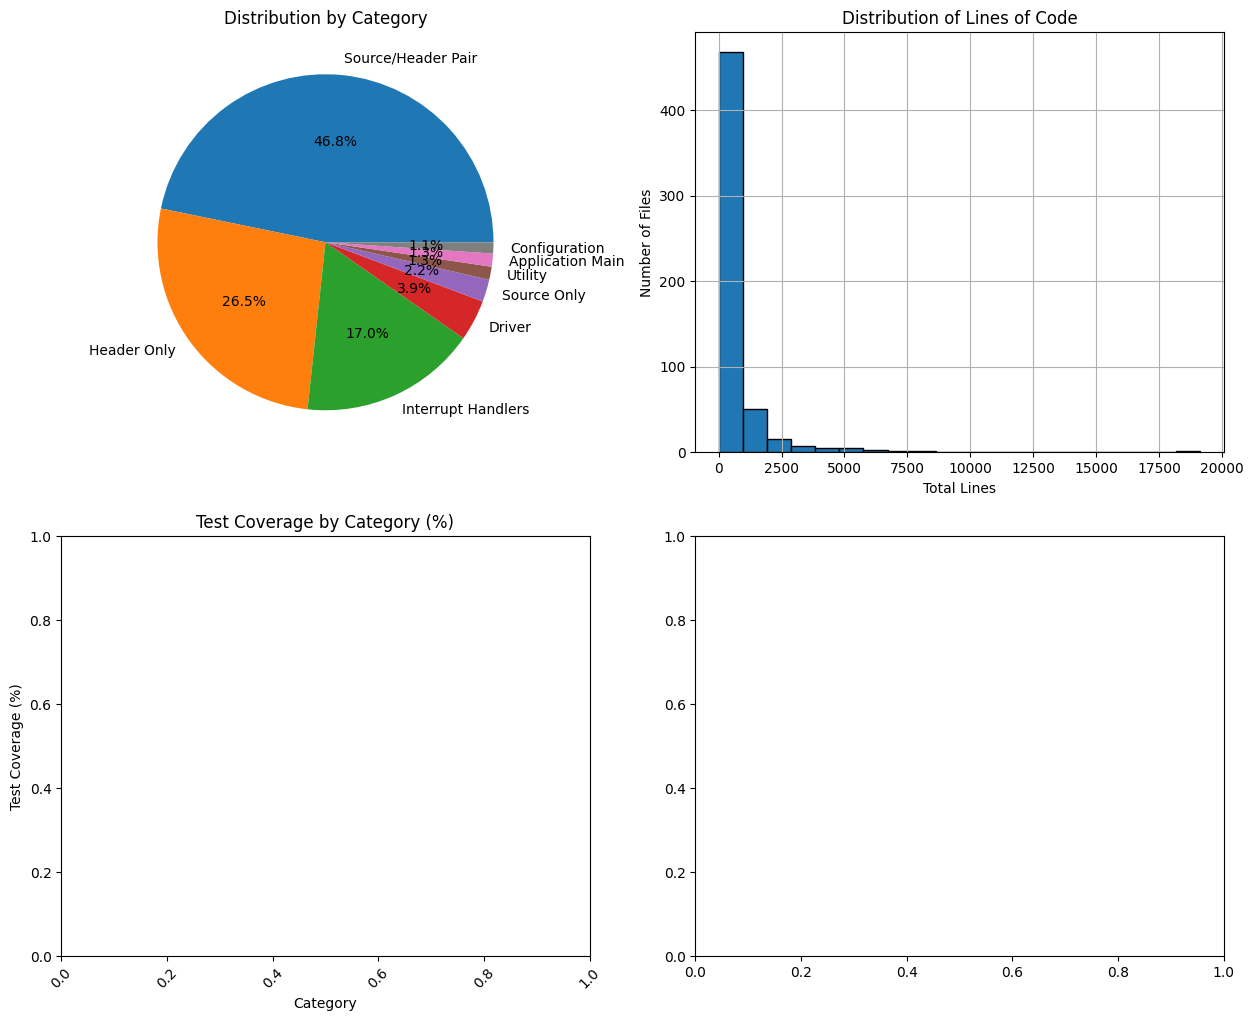

In [6]:
# Load the dataset for analysis
if 'dataset' in globals() and dataset:
    df = pd.DataFrame(dataset)

    print("📊 Dataset Analysis")
    print("=" * 50)

    # Basic statistics
    print(f"📈 Total entries: {len(df)}")
    print(f"📈 Total lines of code: {df['Total Lines'].sum():,}")
    print(f"📈 Average lines per file group: {df['Total Lines'].mean():.1f}")

    # Category distribution
    print(f"\n📋 Distribution by Category:")
    category_counts = df['Category'].value_counts()
    for category, count in category_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")

    # Test coverage
    # files_with_tests = (df['Has Unit Test'] == 'Yes').sum()
    # test_coverage = (files_with_tests / len(df)) * 100
    # print(f"\n🧪 Test Coverage: {files_with_tests}/{len(df)} ({test_coverage:.1f}%)")

    # CMake coverage
    # files_with_cmake = (df['Has CMake'] == 'Yes').sum()
    # cmake_coverage = (files_with_cmake / len(df)) * 100
    # print(f"🔧 CMake Coverage: {files_with_cmake}/{len(df)} ({cmake_coverage:.1f}%)")

    # Visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Category distribution pie chart
    category_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%')
    ax1.set_title('Distribution by Category')
    ax1.set_ylabel('')

    # 2. Lines of code distribution
    df['Total Lines'].hist(bins=20, ax=ax2, edgecolor='black')
    ax2.set_title('Distribution of Lines of Code')
    ax2.set_xlabel('Total Lines')
    ax2.set_ylabel('Number of Files')

    # 3. Test coverage by category
    # test_by_category = df.groupby('Category')['Has Unit Test'].apply(lambda x: (x == 'Yes').sum())
    total_by_category = df['Category'].value_counts()
    # test_percentage = (test_by_category / total_by_category * 100).fillna(0)
    # test_percentage.plot(kind='bar', ax=ax3)
    ax3.set_title('Test Coverage by Category (%)')
    ax3.set_xlabel('Category')
    ax3.set_ylabel('Test Coverage (%)')
    ax3.tick_params(axis='x', rotation=45)

    # 4. File composition
    composition_data = {
        'C files only': ((df['Code1 (.c file)'] != '') & (df['Code2 (.h file)'] == '')).sum(),
        'H files only': ((df['Code1 (.c file)'] == '') & (df['Code2 (.h file)'] != '')).sum(),
        'Both C and H': ((df['Code1 (.c file)'] != '') & (df['Code2 (.h file)'] != '')).sum()
    }

    ax4.bar(composition_data.keys(), composition_data.values())
    ax4.set_title('File Composition')
    ax4.set_ylabel('Number of File Groups')

    plt.tight_layout()
    plt.show()

    # Interactive Plotly charts
    print("\n📊 Interactive Visualizations")

    # Interactive category distribution
    fig_pie = px.pie(values=category_counts.values, names=category_counts.index,
                     title="Category Distribution (Interactive)")
    fig_pie.show()

    # # Interactive scatter plot: Total Lines vs Category
    # # fig_scatter = px.scatter(df, x='Category', y='Total Lines',
    #                        color='Has Unit Test',
    #                        hover_data=['Base File Name'],
    #                        title="Lines of Code by Category and Test Coverage")
    # # fig_scatter.update_xaxis(tickangle=45)
    # fig_scatter.show()

else:
    print("❌ No dataset available for analysis. Please run the dataset creation cell first.")

Cell 7: Download Results

In [7]:
# Download the generated files
print("📥 Download Generated Files")
print("=" * 50)

if 'csv_path' in globals() and csv_path:
    print("Preparing files for download...")

    # Download CSV file
    print("📊 Downloading CSV file...")
    files.download(str(csv_path))

    # Download JSON file
    if 'json_path' in globals() and json_path:
        print("📋 Downloading JSON file...")
        files.download(str(json_path))

    # Create a summary report
    summary_path = creator.output_dir / "dataset_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("Embedded C/C++ Dataset Summary\n")
        f.write("=" * 40 + "\n\n")
        f.write(f"Project: {creator.codebase_path.name}\n")
        f.write(f"Total file groups: {len(dataset)}\n")
        f.write(f"Total lines of code: {df['Total Lines'].sum():,}\n")
        # f.write(f"Files with unit tests: {(df['Has Unit Test'] == 'Yes').sum()}\n")
        # f.write(f"Files with CMake: {(df['Has CMake'] == 'Yes').sum()}\n\n")

        f.write("Category Distribution:\n")
        for category, count in df['Category'].value_counts().items():
            f.write(f"  {category}: {count}\n")

        f.write(f"\nProcessing Statistics:\n")
        f.write(f"  Files processed: {creator.stats['processed_files']}\n")
        f.write(f"  Files skipped: {creator.stats['skipped_files']}\n")
        f.write(f"  Groups created: {creator.stats['groups_created']}\n")

    print("📄 Downloading summary report...")
    files.download(str(summary_path))

    print("\n✅ All files downloaded successfully!")
    print("\nFiles generated:")
    print(f"  📊 {csv_path.name} - Main dataset in CSV format")
    print(f"  📋 {json_path.name} - Training data in JSON format")
    print(f"  📄 {summary_path.name} - Summary report")

else:
    print("❌ No files to download. Please run the dataset creation cell first.")

📥 Download Generated Files
Preparing files for download...
📊 Downloading CSV file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📋 Downloading JSON file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📄 Downloading summary report...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All files downloaded successfully!

Files generated:
  📊 embedded_dataset.csv - Main dataset in CSV format
  📋 grouped_embedded_dataset.json - Training data in JSON format
  📄 dataset_summary.txt - Summary report
